In [2]:

import numpy as np
import matplotlib.pyplot as plt
import operator
import joblib
import random
from sklearn.ensemble import RandomForestClassifier
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import operator
from skimage.segmentation import clear_border
import torch
import math
from tensorflow.keras.models import load_model
from imutils.perspective import four_point_transform
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

In [62]:
def pre_process_image(img, skip_dilate=False):
    # imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # imgGray = cv.cvtColor(img.copy(), cv.COLOR_RGB2GRAY)
    # reduce noise in thresholding algorithm via Gaussian Blur
    proc = cv.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv.adaptiveThreshold(proc, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    
    # in order to successfully extract the grid, we need to invert the colors
    proc = cv.bitwise_not(proc, proc)
    
    # dilation: We need to use dilation as while using Gaussian Thresholding we reduced noise which in
    # turn lead shrinking of our object. So we need to dilate it.
    if not skip_dilate:
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
        proc = cv.dilate(proc, kernel)
    return proc




In [48]:
def find_corners(img, ind):
    
    # ramer doughlas peucker algorithm
    
    
    contours, h = cv.findContours(img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)  # Find contours
    contours = sorted(contours, key=cv.contourArea, reverse=True) 
    polygon = contours[ind] 

    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    return polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]



In [49]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

In [50]:
def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]    
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv.getPerspectiveTransform(src, dst)
    return cv.warpPerspective(img, m, (int(side), int(side)))

In [51]:
def infer_grid(img):
    squares = []
    side = img.shape[:1]
    side = side[0] / 9
    for j in range(9):
        for i in range(9):
            p1 = (i * side, j * side)
            p2 = ((i + 1) * side, (j + 1) * side)
            squares.append((p1, p2))
    return squares

In [52]:
def scale_and_centre(img, size, margin=0, background=0):
    h, w = img.shape[:2]

    def centre_pad(length):
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv.resize(img, (w, h))
    img = cv.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv.BORDER_CONSTANT, None, background)
    return cv.resize(img, (size, size))

In [53]:
def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    img = inp_img.copy()
    height, width = img.shape[:2]
    max_area = 0
    seed_point = (None, None)
    if scan_tl is None:
        scan_tl = [0, 0]
    if scan_br is None:
        scan_br = [width, height]

    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            if img.item(y, x) == 255 and x < width and y < height:
                area = cv.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:
                    max_area = area[0]
                    seed_point = (x, y)
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv.floodFill(img, None, (x, y), 64)

    mask = np.zeros((height + 2, width + 2), np.uint8)

    if all([p is not None for p in seed_point]):
        cv.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = height, 0, width, 0

    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:
                cv.floodFill(img, mask, (x, y), 0)

            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point

In [54]:
def extract_digit(img, rect, size):
    
    digit = img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = digit[int(bbox[0][1]):int(bbox[1][1]), int(bbox[0][0]):int(bbox[1][0])]
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)


In [55]:
def get_digits(img, squares, size):
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True)
    for square in squares:
        digits.append(extract_digit(img, square, size))
    return digits


In [56]:
def predict_image(image):
    # source: https://becominghuman.ai/image-processing-sudokuai-opencv-45380715a629
 
    img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    process = pre_process_image(img.copy())
    # source: https://becominghuman.ai/sudoku-and-cell-extraction-sudokuai-opencv-38b603066066
    
    # sudoku extraction
    polygons = []
    flag = 1
    for i in range(4):
        top_l, top_r, bottom_r, bottom_l  = find_corners(process, i)
        
        # in order to crop the image, we need to know the dimensions of the sudoku.
        width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
        width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
        width = max(int(width_A), int(width_B))

        height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
        height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
        height = max(int(height_A), int(height_B))

        if flag and (abs(width_A - width_B) < width * 0.2 or abs(height_A - height_B) < height * 0.2):
            et = width * height * 0.68
            h = height * 0.3
            w = width * 0.3
            flag = 0
        elif flag:
            et = width * height * 0.68
            h = height * 0.3
            w = width * 0.3

        if i > 0 and (abs(width_A - width_B) > w or abs(height_A - height_B) > h or abs(height - width) > 
                      width * 0.2 or width*height < et):
            continue
        else:
            polygons.append([top_l, top_r, bottom_r, bottom_l])


    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    ordered_corners = find_corners(process, 0)
    res = crop_and_warp(img, ordered_corners)
    dst = np.zeros(img.shape)    
    mask = cv.fillPoly(dst, np.array( [[p[0], p[1], p[2], p[3]] for p in polygons], dtype=np.int32 ), (255,255,255))
    return mask, res

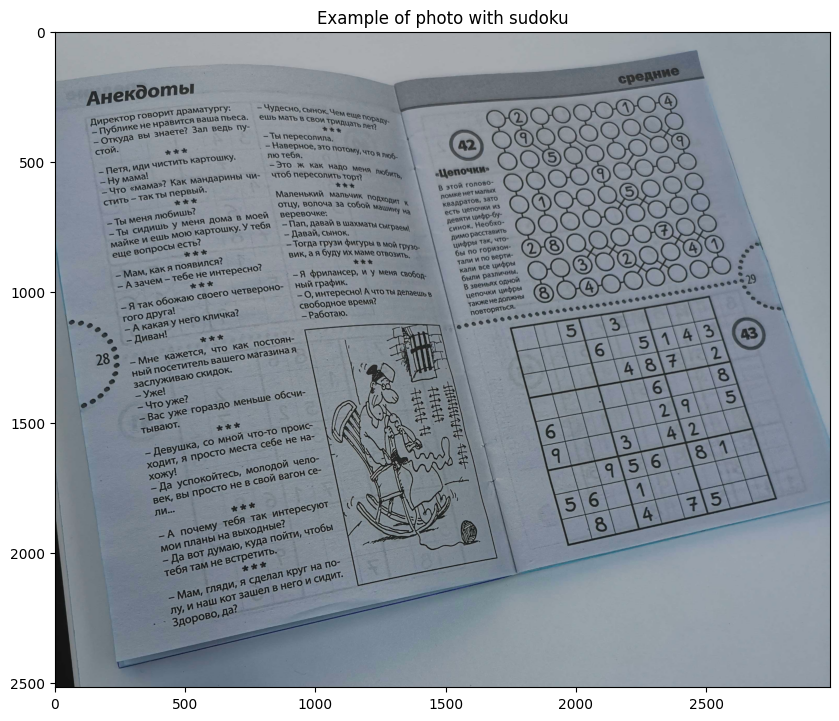

In [78]:
image = cv.imread('train/train_0.jpg')

plt.figure(figsize=(10, 10))
plt.title('Example of photo with sudoku')
plt.imshow(image)


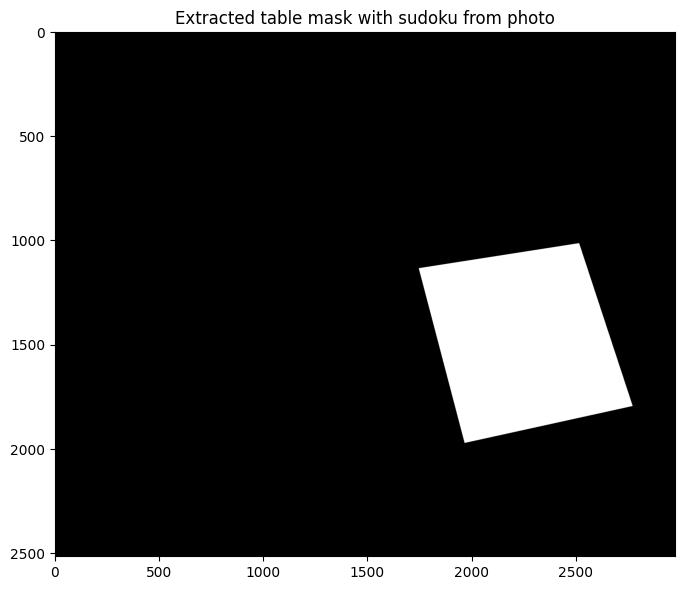

In [79]:
mask, sudoku_table_img = predict_image(image)

plt.figure(figsize=(8,8))
plt.title('Extracted table mask with sudoku from photo')
plt.imshow(mask, cmap='gray')

In [80]:

def show_digits(digits, colour=255):
    rows = []
    with_border = [cv.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv.BORDER_CONSTANT, None, colour) for img in digits]
    for i in range(9):
        row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
        rows.append(row)
    return np.concatenate(rows)

In [81]:
def preprocess_table(sudoku_table):
    squares = infer_grid(sudoku_table)
    digits = get_digits(sudoku_table, squares, 28)
    img = show_digits(digits)
    return img

In [82]:
def recognize_digits(img_table, clf):
    sudoku_digits = np.zeros((9,9))
    for i in range(9):
        for j in range(9):
            image = final_image[i*30:(i+1)*30,j*30:(j+1)*30]
            image = image[1:29,1:29]
            image = cv.resize(image, (28,28))
            kernel = np.ones((2,2))
            image = cv.dilate(image, kernel, iterations=2)
            image = cv.erode(image, kernel, iterations=2)
            if image.sum() > 10000:
                features_test = np.array([image.ravel()])
                sudoku_digits[i][j] = clf.predict(features_test)[0]
            else:
                sudoku_digits[i][j] = -1
    return sudoku_digits

# TRAINING MODEL


In [ ]:

from sklearn.ensemble import RandomForestClassifier

In [83]:

def extract_number(features):
    for path_k in range(9):
        if path_k != 1 and path_k != 3 and path_k != 4:
            # path where your train_images are located
            path = 'train/train_' + str(path_k) + '.jpg'
            print(path)
            img = cv.imread(path)
            _, final_image = predict_image(img)
            final_image = preprocess_table(final_image)
            for i in range(9):
                for j in range(9):
                    image = final_image[i * 30:(i + 1) * 30, j * 30:(j + 1) * 30]
                    image = image[1:29,1:29]
                    image = cv.resize(image, (28, 28))
                    kernel = np.ones((2,2))
                    image = cv.dilate(image, kernel, iterations=2)
                    image = cv.erode(image, kernel, iterations=2)
                    if image.sum() > 10000:
                        features.append(image.ravel())
    return np.array(features)

In [84]:
# labels obtained from images in folder 'data/'
labels_train = np.int16([5,3,6,5,1,4,3,4,8,7,2,6,8,6,2,9,5,9,3,4,2,9,5,6,8,1,5,6,1,8,4,7,5,1,7,8,6,5,1,2,6,5,2,7,3,5,9,2,8,1,
                         4,9,7,1,6,8,4,7,1,5,6,9,7,6,5,7,9,1,4,7,8,3,8,3,1,7,4,6,9,4,3,5,4,9,2,1,6,7,2,5,3,0,8,2,7,1,3,9,2,4,
                         7,5,9,1,3,4,2,3,8,5,2,9,3,6,7,2,9,8,1,2,4,6,3,3,6,5,3,1,9,7,8,1,1,9,8,6,5,7,2,5,3,9,7,8,66,2,6,1,9,7,
                         8,4,1,5,2,4,8,7,2,9,3,9,5,4,7,2,1,7,4,4,5,7,6,5,6,3,2,1,5,1,9,8,6,7,4,8,4,3,6,6,4,8,1,2,8,3,1,5,4,7,
                         1,8,3,4,7])
features_train = []
features_train = extract_number(features_train)

train/train_0.jpg
train/train_2.jpg
train/train_5.jpg
train/train_6.jpg
train/train_7.jpg
train/train_8.jpg


In [85]:
rf = RandomForestClassifier(n_jobs = -1, random_state=42)
rf.fit(features_train, labels_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [86]:
cnn_clf = load_model('model/cnn_classifier.h5')

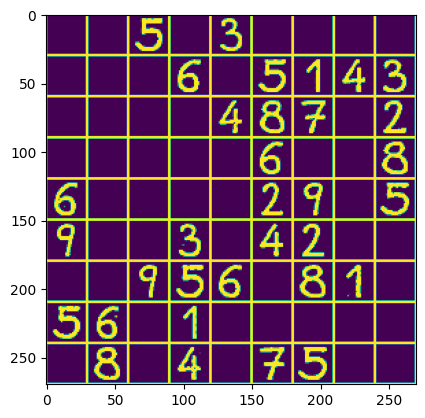

In [87]:
final_img = preprocess_table(sudoku_table_img)
plt.imshow(final_img)

In [89]:
sudoku_digits = np.zeros((9,9))

In [91]:
rf_clf = joblib.load('model/clf.joblib')

c:\Users\danii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [94]:
def recognize(final_img, clf, cnn=False):
    sudoku_digits = np.zeros((9, 9))
    for i in range(9):
        for j in range(9):
            image = final_img[i*30:(i+1)*30,j*30:(j+1)*30]
            image = image[1:29,1:29]
            image = cv.resize(image, (28,28))
            kernel = np.ones((2,2))
            image = cv.dilate(image, kernel, iterations=2)
            image = cv.erode(image, kernel, iterations=2)
            if image.sum() > 10000:
                features_test = np.array([image.ravel()])
                if cnn:
                    features_test = np.expand_dims(features_test.reshape(-1, 28), 0)
                    features_test = np.expand_dims(features_test, -1)
                    sudoku_digits[i][j] = np.argmax(clf.predict(features_test))
                else:
                    sudoku_digits[i][j] = clf.predict(features_test)[0]
            else:
                sudoku_digits[i][j] = -1
    return sudoku_digits

In [96]:
recognize(final_img, rf_clf)

array([[-1., -1.,  5., -1.,  3., -1., -1., -1., -1.],
       [-1., -1., -1.,  6., -1.,  5.,  1.,  4.,  3.],
       [-1., -1., -1., -1.,  4.,  8.,  7., -1.,  2.],
       [-1., -1., -1., -1., -1.,  6., -1., -1.,  8.],
       [ 6., -1., -1., -1., -1.,  2.,  9., -1.,  5.],
       [ 9., -1., -1.,  3., -1.,  4.,  2., -1., -1.],
       [-1., -1.,  9.,  5.,  6., -1.,  8.,  1., -1.],
       [ 5.,  6., -1.,  1., -1., -1., -1., -1., -1.],
       [-1.,  8., -1.,  4., -1.,  7.,  5., -1., -1.]])